## LOAD DATASET (PREPROCESSED DATA)

In [16]:
import tensorflow as tf
from tensorflow.keras.preprocessing import  image_dataset_from_directory
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # To show all logs, including debug messages


In [17]:
# import torch
# print("CUDA available:", torch.cuda.is_available())
# print("GPU name:", torch.cuda.get_device_name(0))

In [18]:
PROCESSED_DATASET_PATH = r"Dataset/ProcessedData"

In [19]:
INPUT_SHAPE = (224, 224, 3)
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.001


# GETTING THE DATASET FROM PREPROCESSED DATASET

In [20]:
dataset = image_dataset_from_directory(
    PROCESSED_DATASET_PATH,
    image_size=(224, 224),
    batch_size=BATCH_SIZE,
    labels="inferred",
    label_mode='categorical',
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="training",
)   


Found 74673 files belonging to 21 classes.
Using 59739 files for training.


In [66]:
classname = [os.listdir(PROCESSED_DATASET_PATH)]
print(classname)

[['0-4', '10-14', '100+', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '5-9', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89', '90-94', '95-99']]


In [22]:
val_dataset = image_dataset_from_directory(
    PROCESSED_DATASET_PATH,
    image_size=(224, 224),
    batch_size=BATCH_SIZE,
    labels="inferred",
    label_mode='categorical',
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="validation",
)

Found 74673 files belonging to 21 classes.
Using 14934 files for validation.


In [23]:

# Prefetch to improve performance
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)


## ASSIGNING THE DATASETS TO THE SPECIFIC VARIABLES 


splitting the dataset to train dataset test dataset and validation dataset

In [24]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2

# PRETRAINED MODEL TRANING

### first making the model freeze andd then traingin the new top layer which we ahve added using our dataset

In [25]:
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=INPUT_SHAPE)
base_model.trainable = False  # Freeze the base model

In [27]:
model = models.Sequential([
    # data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(21, activation="softmax"),
])


In [28]:
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [29]:
callbacks = [
    ModelCheckpoint("Models/Pretrained_best_model.h5", save_best_only=True, monitor="val_accuracy"),
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=3),
]

In [30]:
history = model.fit(
    dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=callbacks,
)


Epoch 1/20
1867/1867 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.1130 - loss: 2.7970

1867/1867 ━━━━━━━━━━━━━━━━━━━━ 402s 214ms/step - accuracy: 0.1130 - loss: 2.7970 - val_accuracy: 0.1686 - val_loss: 2.5380 - learning_rate: 0.0010
Epoch 2/20
1867/1867 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.1538 - loss: 2.5865

1867/1867 ━━━━━━━━━━━━━━━━━━━━ 381s 204ms/step - accuracy: 0.1538 - loss: 2.5865 - val_accuracy: 0.1791 - val_loss: 2.4923 - learning_rate: 0.0010
Epoch 3/20
1867/1867 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.1643 - loss: 2.5489

1867/1867 ━━━━━━━━━━━━━━━━━━━━ 377s 202ms/step - accuracy: 0.1643 - loss: 2.5489 - val_accuracy: 0.1847 - val_loss: 2.4614 - learning_rate: 0.0010
Epoch 4/20
1867/1867 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.1705 - loss: 2.5334

1867/1867 ━━━━━━━━━━━━━━━━━━━━ 374s 200ms/step - accuracy: 0.1705 - loss: 2.5334 - val_accuracy: 0.1931 - val_loss: 2.4456 - learning_rate: 0.0010
Epoch 5/20
1867/1867 ━━━━━━━━━━━━━━━━━━━━ 382s 204ms/step - accuracy: 0.1742 - loss: 2.5199 - val_accuracy: 0.1880 - val_loss: 2.4333 - learning_rate: 0.0010
Epoch 6/20
1867/1867 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.1744 - loss: 2.5096

1867/1867 ━━━━━━━━━━━━━━━━━━━━ 367s 197ms/step - accuracy: 0.1744 - loss: 2.5096 - val_accuracy: 0.1939 - val_loss: 2.4479 - learning_rate: 0.0010
Epoch 7/20
1867/1867 ━━━━━━━━━━━━━━━━━━━━ 369s 198ms/step - accuracy: 0.1774 - loss: 2.5017 - val_accuracy: 0.1916 - val_loss: 2.4224 - learning_rate: 0.0010
Epoch 8/20
1867/1867 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.1829 - loss: 2.4977

1867/1867 ━━━━━━━━━━━━━━━━━━━━ 371s 199ms/step - accuracy: 0.1829 - loss: 2.4977 - val_accuracy: 0.1964 - val_loss: 2.4225 - learning_rate: 0.0010
Epoch 9/20
1867/1867 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.1792 - loss: 2.4928

1867/1867 ━━━━━━━━━━━━━━━━━━━━ 369s 198ms/step - accuracy: 0.1792 - loss: 2.4928 - val_accuracy: 0.1977 - val_loss: 2.4194 - learning_rate: 0.0010
Epoch 10/20
1867/1867 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.1793 - loss: 2.4813

1867/1867 ━━━━━━━━━━━━━━━━━━━━ 367s 197ms/step - accuracy: 0.1793 - loss: 2.4813 - val_accuracy: 0.1990 - val_loss: 2.4228 - learning_rate: 0.0010
Epoch 11/20
1867/1867 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.1807 - loss: 2.4849

1867/1867 ━━━━━━━━━━━━━━━━━━━━ 4330s 2s/step - accuracy: 0.1807 - loss: 2.4849 - val_accuracy: 0.1997 - val_loss: 2.4256 - learning_rate: 0.0010
Epoch 12/20
1867/1867 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.1858 - loss: 2.4763

1867/1867 ━━━━━━━━━━━━━━━━━━━━ 362s 194ms/step - accuracy: 0.1858 - loss: 2.4763 - val_accuracy: 0.2055 - val_loss: 2.4064 - learning_rate: 0.0010
Epoch 13/20
1867/1867 ━━━━━━━━━━━━━━━━━━━━ 1102s 591ms/step - accuracy: 0.1811 - loss: 2.4790 - val_accuracy: 0.2009 - val_loss: 2.4107 - learning_rate: 0.0010
Epoch 14/20
1867/1867 ━━━━━━━━━━━━━━━━━━━━ 1218s 620ms/step - accuracy: 0.1847 - loss: 2.4714 - val_accuracy: 0.2001 - val_loss: 2.4222 - learning_rate: 0.0010
Epoch 15/20
1867/1867 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.1875 - loss: 2.4692

1867/1867 ━━━━━━━━━━━━━━━━━━━━ 360s 193ms/step - accuracy: 0.1875 - loss: 2.4692 - val_accuracy: 0.2057 - val_loss: 2.4054 - learning_rate: 0.0010
Epoch 16/20
1867/1867 ━━━━━━━━━━━━━━━━━━━━ 363s 195ms/step - accuracy: 0.1889 - loss: 2.4651 - val_accuracy: 0.2044 - val_loss: 2.3984 - learning_rate: 0.0010
Epoch 17/20
1867/1867 ━━━━━━━━━━━━━━━━━━━━ 365s 195ms/step - accuracy: 0.1906 - loss: 2.4595 - val_accuracy: 0.2029 - val_loss: 2.3966 - learning_rate: 0.0010
Epoch 18/20
1867/1867 ━━━━━━━━━━━━━━━━━━━━ 367s 197ms/step - accuracy: 0.1880 - loss: 2.4582 - val_accuracy: 0.2049 - val_loss: 2.4014 - learning_rate: 0.0010
Epoch 19/20
1867/1867 ━━━━━━━━━━━━━━━━━━━━ 814s 436ms/step - accuracy: 0.1865 - loss: 2.4632 - val_accuracy: 0.2027 - val_loss: 2.3954 - learning_rate: 0.0010
Epoch 20/20
1867/1867 ━━━━━━━━━━━━━━━━━━━━ 845s 426ms/step - accuracy: 0.1895 - loss: 2.4584 - val_accuracy: 0.2036 - val_loss: 2.3987 - learning_rate: 0.0010


# Fine tuning

In [31]:
base_model.trainable = True # making it true helps use to fine tune the base model

In [32]:
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE * 0.1),  # Lower learning rate for fine-tuning
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [33]:
history_fine = model.fit(
    dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=callbacks,
)


Epoch 1/20
1867/1867 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1749 - loss: 2.7178

1867/1867 ━━━━━━━━━━━━━━━━━━━━ 2294s 1s/step - accuracy: 0.1750 - loss: 2.7176 - val_accuracy: 0.2389 - val_loss: 2.1714 - learning_rate: 1.0000e-04
Epoch 2/20
1867/1867 ━━━━━━━━━━━━━━━━━━━━ 0s 873ms/step - accuracy: 0.2929 - loss: 1.9260

1867/1867 ━━━━━━━━━━━━━━━━━━━━ 1704s 913ms/step - accuracy: 0.2929 - loss: 1.9259 - val_accuracy: 0.2949 - val_loss: 1.9596 - learning_rate: 1.0000e-04
Epoch 3/20
1867/1867 ━━━━━━━━━━━━━━━━━━━━ 0s 828ms/step - accuracy: 0.3688 - loss: 1.6860

1867/1867 ━━━━━━━━━━━━━━━━━━━━ 1622s 869ms/step - accuracy: 0.3688 - loss: 1.6860 - val_accuracy: 0.3440 - val_loss: 1.8311 - learning_rate: 1.0000e-04
Epoch 4/20
1867/1867 ━━━━━━━━━━━━━━━━━━━━ 0s 860ms/step - accuracy: 0.4405 - loss: 1.4856

1867/1867 ━━━━━━━━━━━━━━━━━━━━ 1677s 898ms/step - accuracy: 0.4405 - loss: 1.4855 - val_accuracy: 0.3834 - val_loss: 1.7670 - learning_rate: 1.0000e-04
Epoch 5/20
1867/1867 ━━━━━━━━━━━━━━━━━━━━ 0s 804ms/step - accuracy: 0.4997 - loss: 1.3067

1867/1867 ━━━━━━━━━━━━━━━━━━━━ 1571s 841ms/step - accuracy: 0.4997 - loss: 1.3067 - val_accuracy: 0.4577 - val_loss: 1.5278 - learning_rate: 1.0000e-04
Epoch 6/20
1867/1867 ━━━━━━━━━━━━━━━━━━━━ 0s 814ms/step - accuracy: 0.5567 - loss: 1.1576

1867/1867 ━━━━━━━━━━━━━━━━━━━━ 1591s 852ms/step - accuracy: 0.5567 - loss: 1.1576 - val_accuracy: 0.4992 - val_loss: 1.4497 - learning_rate: 1.0000e-04
Epoch 7/20
1867/1867 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5993 - loss: 1.0396

1867/1867 ━━━━━━━━━━━━━━━━━━━━ 2128s 1s/step - accuracy: 0.5993 - loss: 1.0396 - val_accuracy: 0.5196 - val_loss: 1.4532 - learning_rate: 1.0000e-04
Epoch 8/20
1867/1867 ━━━━━━━━━━━━━━━━━━━━ 1610s 862ms/step - accuracy: 0.6451 - loss: 0.9318 - val_accuracy: 0.4550 - val_loss: 2.0140 - learning_rate: 1.0000e-04
Epoch 9/20
1867/1867 ━━━━━━━━━━━━━━━━━━━━ 1615s 865ms/step - accuracy: 0.6829 - loss: 0.8367 - val_accuracy: 0.5148 - val_loss: 1.6127 - learning_rate: 1.0000e-04
Epoch 10/20
1867/1867 ━━━━━━━━━━━━━━━━━━━━ 0s 807ms/step - accuracy: 0.7424 - loss: 0.6819

1867/1867 ━━━━━━━━━━━━━━━━━━━━ 1579s 846ms/step - accuracy: 0.7425 - loss: 0.6818 - val_accuracy: 0.5955 - val_loss: 1.3896 - learning_rate: 5.0000e-05
Epoch 11/20
1867/1867 ━━━━━━━━━━━━━━━━━━━━ 5153s 3s/step - accuracy: 0.7923 - loss: 0.5546 - val_accuracy: 0.5939 - val_loss: 1.4184 - learning_rate: 5.0000e-05
Epoch 12/20
1867/1867 ━━━━━━━━━━━━━━━━━━━━ 1607s 861ms/step - accuracy: 0.8135 - loss: 0.4858 - val_accuracy: 0.5901 - val_loss: 1.6195 - learning_rate: 5.0000e-05
Epoch 13/20
1867/1867 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.8370 - loss: 0.4306 

1867/1867 ━━━━━━━━━━━━━━━━━━━━ 20047s 11s/step - accuracy: 0.8370 - loss: 0.4306 - val_accuracy: 0.6144 - val_loss: 1.5329 - learning_rate: 5.0000e-05
Epoch 14/20
1867/1867 ━━━━━━━━━━━━━━━━━━━━ 0s 842ms/step - accuracy: 0.8668 - loss: 0.3545

1867/1867 ━━━━━━━━━━━━━━━━━━━━ 1647s 882ms/step - accuracy: 0.8668 - loss: 0.3545 - val_accuracy: 0.6420 - val_loss: 1.5001 - learning_rate: 2.5000e-05
Epoch 15/20
1867/1867 ━━━━━━━━━━━━━━━━━━━━ 1658s 888ms/step - accuracy: 0.8905 - loss: 0.2921 - val_accuracy: 0.6394 - val_loss: 1.6117 - learning_rate: 2.5000e-05


In [35]:
model.save("Models/pretrained_final_model.h5")

# CNN model from Scratch

In [10]:

# Step 1: Define the Model
def create_model1():
    model = models.Sequential([
        # Base Convolutional Layers
        layers.Conv2D(filters = 64, kernel_size = (3, 3), activation='relu', input_shape=INPUT_SHAPE),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(filters = 128, kernel_size = (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
   
        

        # Flatten and Fully Connected Layers
        layers.Flatten(),
        # layers.GlobalAveragePooling2D(),
        layers.Dense(500, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.Dense(256, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        
        
        layers.Dense(21,activation='softmax')  # Final layer for classification
    ])
    return model


In [11]:

# Step 2: Compile the Model
model = create_model1()

model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=0.01),
    loss='sparse_categorical_crossentropy',  # Use sparse_categorical_crossentropy for integer labels
    metrics=['accuracy']
    
)


c:\Users\PUGAZH\Desktop\Projects\DeepLearning\FaceAge_Detection\dlvenv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:

# Step 3: Set Up Callbacks
callbacks = [
    ModelCheckpoint(
        filepath='CNN_model_best.h5',  # Save the best model
        save_best_only=True,
        monitor='val_accuracy',  # Monitor validation accuracy
        mode='max',
        verbose=1
    ),
    EarlyStopping(
        patience=5,  # Stop training if no improvement for 5 epochs
        monitor='val_loss',
        mode='min',
        verbose=1,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,  # Reduce learning rate by a factor of 0.2
        patience=3,  # If no improvement for 3 epochs
        min_lr=1e-6,
        verbose=1
    )
]



In [14]:
# Step 4: Train the Model
history = model.fit(
    dataset,
    validation_data=val_dataset,
    epochs=30,
    
    callbacks=callbacks,
    verbose=1
)



Epoch 1/10
854/854 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0852 - loss: 173.8300
Epoch 1: val_accuracy improved from -inf to 0.07668, saving model to model_best.h5


854/854 ━━━━━━━━━━━━━━━━━━━━ 1166s 1s/step - accuracy: 0.0852 - loss: 173.7273 - val_accuracy: 0.0767 - val_loss: 9.2749 - learning_rate: 0.0100
Epoch 2/10
691/854 ━━━━━━━━━━━━━━━━━━━━ 3:40 1s/step - accuracy: 0.0841 - loss: 6.8073

KeyboardInterrupt: 

In [15]:
# Step 5: Evaluate the Model
test_loss, test_accuracy = model.evaluate(val_dataset, verbose=1)
print(f"Test Accuracy: {test_accuracy:.2f}")

108/108 ━━━━━━━━━━━━━━━━━━━━ 28s 257ms/step - accuracy: 0.3198 - loss: 2.6868
Test Accuracy: 0.32


In [19]:
# import os
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.preprocessing.image import load_img, img_to_array
# from tensorflow.keras.models import load_model

# def predict_age_from_image(image_path, model_path='model_best.h5', image_size=(224, 224)):
#     """
#     Given an image file path, this function will:
#     1. Load the pre-trained model from a specified path.
#     2. Preprocess the image (resize and normalize).
#     3. Make a prediction on the age.
#     4. Return the predicted age.
    
#     Parameters:
#     - image_path: Path to the image file for which the age is to be predicted.
#     - model_path: Path to the saved trained model (.h5 format).
#     - image_size: Target size for resizing the image to match the model input (default: (224, 224)).
    
#     Returns:
#     - predicted_age: The predicted age (a discrete value).
#     """
    
#     try:
#         # ------------------- Step 1: Load the Trained Model ------------------- #
#         model = load_model(model_path)  # Load the model from the specified path
#         print(f"Model loaded successfully from {model_path}")
        
#     except Exception as e:
#         print(f"Error loading the model: {e}")
#         return None
    
#     try:
#         # ------------------- Step 2: Preprocess the Input Image ------------------- #
#         # Load the image
#         image = load_img(image_path, target_size=image_size)  # Resize the image
#         image = img_to_array(image)  # Convert image to a NumPy array
        
#         # Normalize the image (scale pixel values to range [0, 1])
#         image = tf.cast(image, tf.float32) / 255.0
        
#         # Add a batch dimension (model expects a batch of images, not just one)
#         image = np.expand_dims(image, axis=0)  # Shape: (1, 224, 224, 3)
#         print(f"Image preprocessed successfully: {image.shape}")
        
#     except Exception as e:
#         print(f"Error preprocessing the image {image_path}: {e}")
#         return None
    
#     try:
#         # ------------------- Step 3: Make the Prediction ------------------- #
#         # Predict the output using the model (returns a probability distribution over ages)
#         prediction = model.predict(image)
        
#         # Get the index of the highest probability (i.e., the predicted age)
#         predicted_age = np.argmax(prediction)  # Index with the highest probability
#         print(f"Predicted age: {predicted_age}")
        
#         return predicted_age  # Return the predicted age
        
#     except Exception as e:
#         print(f"Error making prediction for {image_path}: {e}")
#         return None

# # Example usage:
# image_path = 'path_to_image.jpg'  # Replace with the actual image path
# predicted_age = predict_age_from_image(r"C:\Users\PUGAZH\Desktop\Projects\DeepLearning\FaceAge_Detection\src\Dataset\ProcessedData\81-90\81_0_0_20170111222146910.jpg.chip.jpg")

# if predicted_age is not None:
#     print(f"The predicted age for the given image is: {predicted_age}")


Model loaded successfully from model_best.h5
Image preprocessed successfully: (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Predicted age: 10
The predicted age for the given image is: 10


In [95]:
def load_and_predict(image_path, model_path=r"C:\Users\PUGAZH\Desktop\Projects\DeepLearning\FaceAge_Detection\src\Models\pretrained_best_model.h5"):
    model = tf.keras.models.load_model(model_path)
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Add batch dimension
    predictions = model.predict(img_array)
    predicted_class = tf.argmax(predictions[0]).numpy()
    return classname[0][predicted_class]

image_path = 'path_to_image.jpg'  # Replace with the actual image path
predicted_age = load_and_predict(r"C:\Users\PUGAZH\Downloads\images (1).jpeg")

if predicted_age is not None:
    print(f"The predicted age for the given image is: {predicted_age}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step
The predicted age for the given image is: 80-84


# METRICS OF PRETRAINED MODEL

In [78]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history.get('accuracy')  # Only if you use accuracy as a metric
val_acc = history.history.get('val_accuracy')


[2.6924431324005127, 2.5754268169403076, 2.5430877208709717, 2.5268819332122803, 2.5169522762298584, 2.507566213607788, 2.4976155757904053, 2.4942259788513184, 2.4872772693634033, 2.4809646606445312, 2.48079776763916, 2.474504232406616, 2.47373366355896, 2.4675042629241943, 2.464092254638672, 2.4618818759918213, 2.4556994438171387, 2.455275058746338, 2.45559024810791, 2.4568066596984863]    [0.13302867114543915, 0.15659786760807037, 0.16536936163902283, 0.17080968618392944, 0.1736888736486435, 0.1747267246246338, 0.17748874425888062, 0.1806190311908722, 0.1795644313097, 0.18008336424827576, 0.18085338175296783, 0.18515542149543762, 0.18281190097332, 0.18376605212688446, 0.1865113228559494, 0.18689633905887604, 0.18979226052761078, 0.1878337413072586, 0.1882857084274292, 0.19037814438343048]   [0.16860854625701904, 0.17905451357364655, 0.18474622070789337, 0.19311638176441193, 0.18802732229232788, 0.19385294616222382, 0.19164322316646576, 0.19639748334884644, 0.19766974449157715, 0.1990

### PLOTTING GRAPH

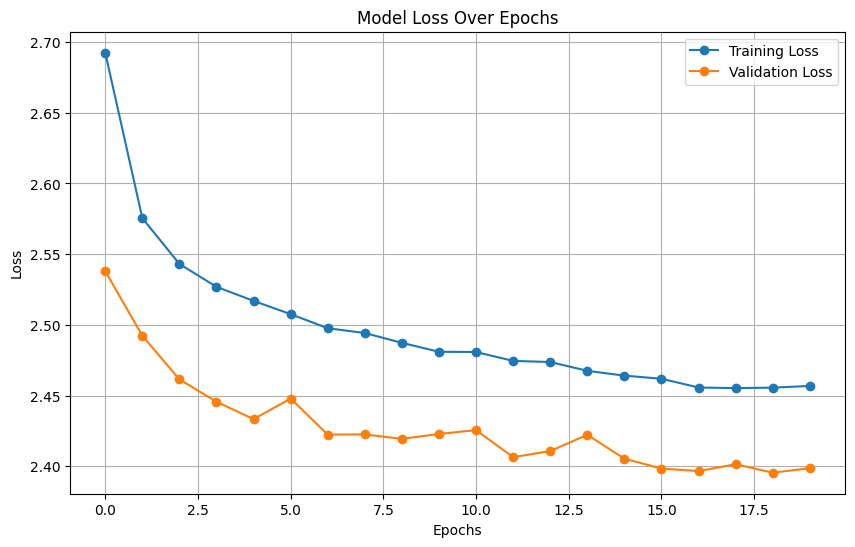

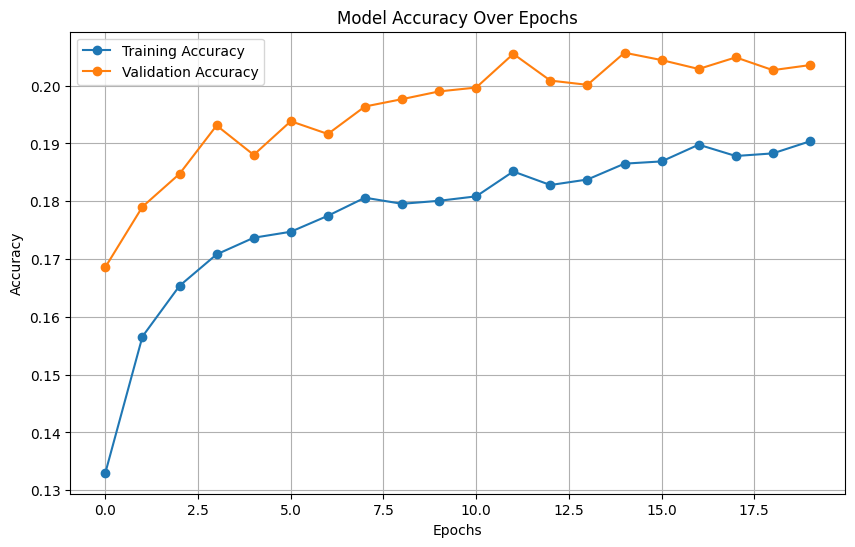

In [74]:
import matplotlib.pyplot as plt

# Plot loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot accuracy (if available)
if 'accuracy' in history.history:
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title('Model Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()
